In [16]:
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import pickle
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
from localcider.sequenceParameters import SequenceParameters
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
import math
import numpy as np
from collections import Counter
from Bio import SeqIO
import os
print(os.path.abspath(os.getcwd()))
curr_wd = os.path.abspath(os.getcwd())

def count_consecutive_stretches_of_1(lst, label="IDR"):
    count = 0
    current_stretch = False
    start_stop_list = []
    for index, num in enumerate(lst):
        if num == 1:
            if current_stretch == False:
                start = index
                current_stretch = True
                count += 1
        else:
            if current_stretch == True:
                current_stretch = False
                stop = index
                start_stop_list.append((start, stop, label))
    if current_stretch == True:
        start_stop_list.append((start, len(lst), label))
    return start_stop_list
### count_consecutive_stretches_of_1([1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], "IDR") --> [(0, 4, 'IDR'), (13, 21, 'IDR')]


def is_either_between(low_range, high_range, a, b):
    ### a and b are start and end of the motif
    ### low_range and high_range are the start and end of the IDR
    ### it will output true if the motif only as much as toucehs the IDR region
    return (low_range <= a <= high_range) or (low_range <= b <= high_range)

def assign_group(protein, group1_name: list, group1_string, group2_name: list, group2_string ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    else:
        return 'Not in any group'


motif_info_set_df = pd.read_parquet(curr_wd + '/data/processed/' + 'GAR_motif_Wang_set_human_cleaned_annot_filtered.parquet')
annotated_IDR_df = pd.read_parquet(curr_wd + '/data/processed/' + 'annotation_datasets/all_IDR_human.parquet')
annotated_domain_df = pd.read_parquet(curr_wd + '/data/processed/' + 'annotation_datasets/all_domains_human.parquet')

/mnt/d/phd/scripts/11_pub_hu-RG-motif-composition_analysis


In [17]:
ver = "v3"

set_names, set_list, set_files = [], [], []

GAR_full = ["GAR_subset_full"]
set_names.append("GAR_full")
set_files.append(GAR_full)
#########
GAR_LLPS_pos = ["4_LLPS_positive_set_and_GAR_subset",
                "5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
                ]
set_names.append("GAR_LLPS_pos")
set_files.append(GAR_LLPS_pos)
###################
GAR_LLPS_pos_NA_neg = ["4_LLPS_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_pos_NA_neg")
set_files.append(GAR_LLPS_pos_NA_neg)
#########

GAR_LLPS_neg = ["6_NA_positive_set_and_GAR_subset",
                "7_GAR_subset_only"
            ]
set_names.append("GAR_LLPS_neg")
set_files.append(GAR_LLPS_neg)
#################
GAR_LLPS_neg_NA_pos = ["6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_neg_NA_pos")
set_files.append(GAR_LLPS_neg_NA_pos)

#########
GAR_NA_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset",
            "6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_NA_pos")
set_files.append(GAR_NA_pos)
#########
GAR_NA_neg = ["4_LLPS_positive_set_and_GAR_subset",
            "7_GAR_subset_only"
            ]
set_names.append("GAR_NA_neg")
set_files.append(GAR_NA_neg)
#########
GAR_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_pos")
set_files.append(GAR_pos)
#########
#########
GAR_neg = ["7_GAR_subset_only"
            ]
set_names.append("GAR_neg")
set_files.append(GAR_neg)
#########



set_list = []
set_dict = {}
proteins_sets_dict = {}
for i,member in enumerate(set_files):
    set_list_temp = []
    for el in member:
        with open(curr_wd + '/data/processed/' + 'final_set_lists/' + el +".txt", "r") as fl:
            for line in fl:
                set_list_temp.append(line.strip())
    set_dict[set_names[i]] = set_list_temp
    set_list.append(set_list_temp)
set_list_temp = []
with open(curr_wd + '/data/processed/' + 'list_of_human_proteins.csv') as fl:
    for line in fl:
        set_list_temp.append(line.strip())
set_list.append(set_list_temp)
set_names.append('full_proteome')
set_dict['full_proteome'] = set_list_temp

proteins_sets_dict[ver] = set_dict

In [20]:
protein_dict_with_physchem_metrics = {}
for i,curr_protein in enumerate(proteins_sets_dict['v3']['full_proteome']):
    # if i == 200: break
    if motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein].empty:
        continue
    print(i, " out of ", len(proteins_sets_dict['v3']['full_proteome']))
    print(curr_protein)
    if annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein].empty:
        print("NO IDR")
        continue
    IDR_info_curr = annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein]["prediction-disorder-mobidb_lite"].tolist()[0].tolist()
    # print(IDR_info_curr)
    IDR_bounds = count_consecutive_stretches_of_1(IDR_info_curr)
    # print(IDR_bounds)
    protein_dict_with_physchem_metrics[curr_protein] = {}
    for i2, row2 in motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein].iterrows():
        # print(row2["start"])
        # print(row2["end"])

        
        flag_calc_entire_IDR = True
        protein_dict_with_physchem_metrics[curr_protein][i2]= {
                "full_seq": row2["full_seq"],
                "motif_seq": row2["motif"],
                "RG_count": row2["RG_count"],
                "RG_count_rel": row2["RG_count"]/len(row2["motif"]),
                "RGG_count": row2["RGG_count"],
                "RGG_count_rel": row2["RGG_count"]/len(row2["motif"]),
                "perc_impure": 100 - (row2["r_perc"] + row2["g_perc"]),
                "len_motif": len(row2["motif"]),
                "len_motif_rel": len(row2["motif"])/len(row2["full_seq"]), 
                "other_aas_array": ProteinAnalysis(row2["motif"]).count_amino_acids(),



                "ncpr_motif": SequenceParameters(row2["motif"]).get_NCPR(),
                "ncpr_motif+40": np.nan,
                "ncpr_motif-40": np.nan,
                "ncpr_motif+30": np.nan,
                "ncpr_motif-30": np.nan,
                "ncpr_motif+10": np.nan,
                "ncpr_motif-10": np.nan,
                "ncpr_motif+20": np.nan,
                "ncpr_motif-20": np.nan,
                "ncpr_motifIDR": np.nan,

                "hyphob_motif": SequenceParameters(row2["motif"]).get_mean_hydropathy(),
                "hyphob_motif+40": np.nan,
                "hyphob_motif-40": np.nan,
                "hyphob_motif+30": np.nan,
                "hyphob_motif-30": np.nan,
                "hyphob_motif+10": np.nan,
                "hyphob_motif-10": np.nan,
                "hyphob_motif+20": np.nan,
                "hyphob_motif-20": np.nan,
                "hyphob_motifIDR": np.nan,

                "kappa_motif": SequenceParameters(row2["motif"]).get_kappa(),
                "kappa_motif+30": np.nan,
                "kappa_motif-30": np.nan,
                "kappa_motif+40": np.nan,
                "kappa_motif-30": np.nan,
                "kappa_motif+10": np.nan,
                "kappa_motif-10": np.nan,
                "kappa_motif+20": np.nan,
                "kappa_motif-20": np.nan,
                "kappa_motifIDR": np.nan,

                "aroma_motif": ProteinAnalysis(row2["motif"]).aromaticity(),
                "aroma_motif+40": np.nan,
                "aroma_motif-40": np.nan,
                "aroma_motif+30": np.nan,
                "aroma_motif-30": np.nan,
                "aroma_motif+10": np.nan,
                "aroma_motif-10": np.nan,
                "aroma_motif+20": np.nan,
                "aroma_motif-20": np.nan,
                "aroma_motifIDR": np.nan,

                ## flexibility
                "scd_motif": SequenceParameters(row2["motif"]).get_SCD(),
                "scd_motif+40": np.nan,
                "scd_motif-40": np.nan,
                "scd_motif+30": np.nan,
                "scd_motif-30": np.nan,
                "scd_motif+10": np.nan,
                "scd_motif-10": np.nan,
                "scd_motif+20": np.nan,
                "scd_motif-20": np.nan,
                "scd_motifIDR": np.nan,

                "disorder_promo_motif": SequenceParameters(row2["motif"]).get_fraction_disorder_promoting(),
                "disorder_promo_motif+40": np.nan,
                "disorder_promo_motif-40": np.nan,
                "disorder_promo_motif+30": np.nan,
                "disorder_promo_motif-30": np.nan,
                "disorder_promo_motif+10": np.nan,
                "disorder_promo_motif-10": np.nan,
                "disorder_promo_motif+20": np.nan,
                "disorder_promo_motif-20": np.nan,
                "disorder_promo_motifIDR": np.nan,

                "flex_motif": sum(ProteinAnalysis(row2["motif"]).flexibility())/len(ProteinAnalysis(row2["motif"]).flexibility()) if len(ProteinAnalysis(row2["motif"]).flexibility()) != 0 else math.nan,
                "flex_motif+40": np.nan,
                "flex_motif-40": np.nan,
                "flex_motif+30": np.nan,
                "flex_motif-30": np.nan,
                "flex_motif+10": np.nan,
                "flex_motif-10": np.nan,
                "flex_motif+20": np.nan,
                "flex_motif-20": np.nan,
                "flex_motifIDR": np.nan,
            }
        # print(el)
        # el = (row2["start"],row2["end"])
        flag_calc_entire_IDR = False
        for el in IDR_bounds:
            if is_either_between(el[0], el[1],row2["start"] , row2["end"]):
                motif_IDR_bounds = (el[0], el[1])
                flag_calc_entire_IDR = True
                break

        if flag_calc_entire_IDR == False:
            motif_IDR_bounds = (row2["start"],row2["end"])
            # print("THIS IS NOT SUPPOSED TO HAPPEN!")
            # flag_calc_entire_IDR = False
            # el = (row2["start"],row2["end"])
        # print(IDR_bounds)
        
        motif_seq = row2["motif"]
        left_diff = row2["start"] - motif_IDR_bounds[0]
        right_diff = motif_IDR_bounds[1] - row2["end"]
        # print(left_diff)
        # print(right_diff)
        if left_diff >= 40:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif-40"] = SequenceParameters(row2["full_seq"][row2["start"]-40:row2["start"]-30]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif-40"] = SequenceParameters(row2["full_seq"][row2["start"]-40:row2["start"]-30]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif-40"] = SequenceParameters(row2["full_seq"][row2["start"]-40:row2["start"]-30]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif-40"] = ProteinAnalysis(row2["full_seq"][row2["start"]-40:row2["start"]-30]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif-40"] = sum(ProteinAnalysis(row2["full_seq"][row2["start"]-40:row2["start"]-30]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["start"]-40:row2["start"]-30]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif-40"] = SequenceParameters(row2["full_seq"][row2["start"]-40:row2["start"]-30]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif-40"] = SequenceParameters(row2["full_seq"][row2["start"]-40:row2["start"]-30]).get_fraction_disorder_promoting()
        if left_diff >= 30:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif-30"] = SequenceParameters(row2["full_seq"][row2["start"]-30:row2["start"]-20]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif-30"] = SequenceParameters(row2["full_seq"][row2["start"]-30:row2["start"]-20]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif-30"] = SequenceParameters(row2["full_seq"][row2["start"]-30:row2["start"]-20]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif-30"] = ProteinAnalysis(row2["full_seq"][row2["start"]-30:row2["start"]-20]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif-30"] = sum(ProteinAnalysis(row2["full_seq"][row2["start"]-30:row2["start"]-20]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["start"]-30:row2["start"]-20]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif-30"] = SequenceParameters(row2["full_seq"][row2["start"]-30:row2["start"]-20]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif-30"] = SequenceParameters(row2["full_seq"][row2["start"]-30:row2["start"]-20]).get_fraction_disorder_promoting()
        if left_diff >= 20:
            #### do here the calcs for all the groups left
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif-20"] = SequenceParameters(row2["full_seq"][row2["start"]-20:row2["start"]-10]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif-20"] = SequenceParameters(row2["full_seq"][row2["start"]-20:row2["start"]-10]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif-20"] = SequenceParameters(row2["full_seq"][row2["start"]-20:row2["start"]-10]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif-20"] = ProteinAnalysis(row2["full_seq"][row2["start"]-20:row2["start"]-10]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif-20"] = sum(ProteinAnalysis(row2["full_seq"][row2["start"]-20:row2["start"]-10]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["start"]-20:row2["start"]-10]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif-20"] = SequenceParameters(row2["full_seq"][row2["start"]-20:row2["start"]-10]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif-20"] = SequenceParameters(row2["full_seq"][row2["start"]-20:row2["start"]-10]).get_fraction_disorder_promoting()
        if left_diff >= 10:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif-10"] = SequenceParameters(row2["full_seq"][row2["start"]-10:row2["start"]]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif-10"] = SequenceParameters(row2["full_seq"][row2["start"]-10:row2["start"]]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif-10"] = SequenceParameters(row2["full_seq"][row2["start"]-10:row2["start"]]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif-10"] = ProteinAnalysis(row2["full_seq"][row2["start"]-10:row2["start"]]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif-10"] = sum(ProteinAnalysis(row2["full_seq"][row2["start"]-10:row2["start"]]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["start"]-10:row2["start"]]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif-10"] = SequenceParameters(row2["full_seq"][row2["start"]-10:row2["start"]]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif-10"] = SequenceParameters(row2["full_seq"][row2["start"]-10:row2["start"]]).get_fraction_disorder_promoting()
            ### do here the calcs for all the groups left, except for the 20 groups, use left_ext instead of 20

        #     ### do here the calcs for all the groups left, except for the 20 groups, and use left_diff for the 10 group

        if right_diff >= 40:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif+40"] = SequenceParameters(row2["full_seq"][row2["end"]+30:row2["end"]+40]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif+40"] = SequenceParameters(row2["full_seq"][row2["end"]+30:row2["end"]+40]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif+40"] = SequenceParameters(row2["full_seq"][row2["end"]+30:row2["end"]+40]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif+40"] = ProteinAnalysis(row2["full_seq"][row2["end"]+30:row2["end"]+40]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif+40"] = sum(ProteinAnalysis(row2["full_seq"][row2["end"]+30:row2["end"]+40]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["end"]+30:row2["end"]+40]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif+40"] = SequenceParameters(row2["full_seq"][row2["end"]+30:row2["end"]+40]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif+40"] = SequenceParameters(row2["full_seq"][row2["end"]+30:row2["end"]+40]).get_fraction_disorder_promoting()
        if right_diff >= 30:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif+30"] = SequenceParameters(row2["full_seq"][row2["end"]+20:row2["end"]+30]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif+30"] = SequenceParameters(row2["full_seq"][row2["end"]+20:row2["end"]+30]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif+30"] = SequenceParameters(row2["full_seq"][row2["end"]+20:row2["end"]+30]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif+30"] = ProteinAnalysis(row2["full_seq"][row2["end"]+20:row2["end"]+30]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif+30"] = sum(ProteinAnalysis(row2["full_seq"][row2["end"]+20:row2["end"]+30]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["end"]+20:row2["end"]+30]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif+30"] = SequenceParameters(row2["full_seq"][row2["end"]+20:row2["end"]+30]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif+30"] = SequenceParameters(row2["full_seq"][row2["end"]+20:row2["end"]+30]).get_fraction_disorder_promoting()
        if right_diff >= 20:
            #### do here the calcs for all the groups left
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif+20"] = SequenceParameters(row2["full_seq"][row2["end"]+10:row2["end"]+20]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif+20"] = SequenceParameters(row2["full_seq"][row2["end"]+10:row2["end"]+20]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif+20"] = SequenceParameters(row2["full_seq"][row2["end"]+10:row2["end"]+20]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif+20"] = ProteinAnalysis(row2["full_seq"][row2["end"]+10:row2["end"]+20]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif+20"] = sum(ProteinAnalysis(row2["full_seq"][row2["end"]+10:row2["end"]+20]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["end"]+10:row2["end"]+20]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif+20"] = SequenceParameters(row2["full_seq"][row2["end"]+10:row2["end"]+20]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif+20"] = SequenceParameters(row2["full_seq"][row2["end"]+10:row2["end"]+20]).get_fraction_disorder_promoting()
        if right_diff >= 10:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motif+10"] = SequenceParameters(row2["full_seq"][row2["end"]:row2["end"]+10]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motif+10"] = SequenceParameters(row2["full_seq"][row2["end"]:row2["end"]+10]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motif+10"] = SequenceParameters(row2["full_seq"][row2["end"]:row2["end"]+10]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motif+10"] = ProteinAnalysis(row2["full_seq"][row2["end"]:row2["end"]+10]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motif+10"] = sum(ProteinAnalysis(row2["full_seq"][row2["end"]:row2["end"]+10]).flexibility())/len(ProteinAnalysis(row2["full_seq"][row2["end"]:row2["end"]+10]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motif+10"] = SequenceParameters(row2["full_seq"][row2["end"]:row2["end"]+10]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motif+10"] = SequenceParameters(row2["full_seq"][row2["end"]:row2["end"]+10]).get_fraction_disorder_promoting()
            ### do here the calcs for all the groups left, except for the 20 groups, use left_ext instead of 20

        
        
        
        
        if flag_calc_entire_IDR:
            protein_dict_with_physchem_metrics[curr_protein][i2]["ncpr_motifIDR"] = SequenceParameters(row2["full_seq"][el[0]:el[1]]).get_NCPR()
            protein_dict_with_physchem_metrics[curr_protein][i2]["hyphob_motifIDR"] = SequenceParameters(row2["full_seq"][el[0]:el[1]]).get_mean_hydropathy()
            protein_dict_with_physchem_metrics[curr_protein][i2]["kappa_motifIDR"] = SequenceParameters(row2["full_seq"][el[0]:el[1]]).get_kappa()
            protein_dict_with_physchem_metrics[curr_protein][i2]["aroma_motifIDR"] = ProteinAnalysis(row2["full_seq"][el[0]:el[1]]).aromaticity()
            protein_dict_with_physchem_metrics[curr_protein][i2]["flex_motifIDR"] = sum(ProteinAnalysis(row2["full_seq"][el[0]:el[1]]).flexibility())/len(ProteinAnalysis(row2["full_seq"][el[0]:el[1]]).flexibility())
            protein_dict_with_physchem_metrics[curr_protein][i2]["scd_motifIDR"] = SequenceParameters(row2["full_seq"][el[0]:el[1]]).get_SCD()
            protein_dict_with_physchem_metrics[curr_protein][i2]["disorder_promo_motifIDR"] = SequenceParameters(row2["full_seq"][el[0]:el[1]]).get_fraction_disorder_promoting()
    
_prot_list, _mot_list, _metric_list, _data_list = [], [], [], []
for ki,vi in protein_dict_with_physchem_metrics.items():
    curr_prot = ki
    for kii, vii in vi.items():
                curr_mot = kii
                for kiii, viii in vii.items():
                    curr_metric = kiii
                    curr_data = viii
                    # print(curr_prot, curr_set, curr_aa, curr_metric, curr_data)
                    _prot_list.append(curr_prot)
                    _mot_list.append(curr_mot)
                    _metric_list.append(curr_metric)
                    _data_list.append(curr_data)

protein_df_with_physchem_metrics = pd.DataFrame({
    'prot': _prot_list,
    'mot': _mot_list,
    'metric': _metric_list,
    'data': _data_list
})
print(len(protein_df_with_physchem_metrics))

protein_df_with_physchem_metrics_cleaned = protein_df_with_physchem_metrics.dropna(subset=['data'])

print(len(protein_df_with_physchem_metrics_cleaned))
protein_df_with_physchem_metrics_cleaned.reset_index(inplace=True)

protein_df_with_physchem_metrics_cleaned['Group'] = protein_df_with_physchem_metrics_cleaned['prot'].apply(
                                                                    assign_group,
                                                                    args= (set_list[set_names.index("GAR_pos")], "pos", set_list[set_names.index("GAR_neg")], "neg"))
protein_df_with_physchem_metrics_cleaned = protein_df_with_physchem_metrics_cleaned.infer_objects()
protein_df_with_physchem_metrics_cleaned.dtypes
protein_df_with_physchem_metrics_cleaned

with open(curr_wd + '/data/results/' + 'protein_dict_with_physchem_metrics.pkl', 'wb') as fp:
    pickle.dump(protein_dict_with_physchem_metrics, fp)
    print('dictionary saved successfully to file')

48  out of  20580
Q5SSQ6
61  out of  20580
Q7Z7L8
72  out of  20580
Q8NAF0
94  out of  20580
Q9ULH4
162  out of  20580
Q8N878
238  out of  20580
P85299
281  out of  20580
Q9GZU7
321  out of  20580
O95677
369  out of  20580
Q96HM7
383  out of  20580
Q9H461
420  out of  20580
P30414
429  out of  20580
Q14674
443  out of  20580
Q5VUG0
451  out of  20580
Q7L8J4
459  out of  20580
Q8N539
486  out of  20580
Q9HBH9
509  out of  20580
O00453
531  out of  20580
P0CJ87
544  out of  20580
P86481
545  out of  20580
Q01954
569  out of  20580
Q86XE3
601  out of  20580
A0FGR8
606  out of  20580
O15014
637  out of  20580
Q13151
664  out of  20580
Q8N1G1
692  out of  20580
Q9UH36
707  out of  20580
A6NEQ0
784  out of  20580
Q99502
803  out of  20580
A0A590UJ96
824  out of  20580
P20339
908  out of  20580
B2RXF0
956  out of  20580
Q6NV74
976  out of  20580
Q96SZ5
1008  out of  20580
O15417
1059  out of  20580
Q8IUG5
1126  out of  20580
P36021
1180  out of  20580
Q9HCU4
1190  out of  20580
Q9UJV8
1196  o

KeyboardInterrupt: 

In [ ]:
with open(curr_wd + '/data/results/' + 'protein_dict_with_physchem_metrics.pkl', 'rb') as fp:
    protein_dict_with_physchem_metrics = pickle.load(fp)
protein_dict_with_physchem_metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare amino acid groupings
amino_acid_groupings = [
    ["F", "Y", "W"], 
    ["E", "D", "N", "Q"], 
    ["L", "V", "I", "M", "C"], 
    ["K", "H"], 
    ["A", "S", "T", "P"]
]
amino_acids_high_values = ["R", "G"]

categories_ordered = ["neg", "pos"]
metrics_ordered = ["other_aas_array"]

cut_data = protein_df_with_physchem_metrics_cleaned[protein_df_with_physchem_metrics_cleaned["Group"].isin(categories_ordered)]
condition_2 = cut_data['metric'].isin(metrics_ordered)
cut_data = cut_data[condition_2]
cut_data = cut_data.infer_objects()

df = cut_data.drop(columns=["index", "prot", "mot"])
# print(df)
# Step 1: Explode the dictionary in the 'data' column into separate columns
data_expanded = pd.json_normalize(df['data'])

# print(data_expanded)

df_expanded = pd.concat([df.reset_index(drop=True), data_expanded], axis=1).drop(columns=['data'])
# print(df_expanded)
df_expanded
# Step 2: Specify the keys (letters) to exclude (example: exclude 'B' and 'C')
# keys_to_exclude = ['R', 'G']

# Step 3: Drop the specified keys from the DataFrame
# df_expanded = df_expanded.drop(columns=keys_to_exclude, errors='ignore')
# Step 2: Group by 'Group' and calculate sum for each key
group_sums = df_expanded.groupby('Group').sum()
print(group_sums)
# group_sums = group_sums.loc[:, (group_sums.sum(axis=0) != 0)]
# Step 3: Calculate the relative proportions for each group
group_proportions = group_sums.div(group_sums.sum(axis=1), axis=0)*100

def extract_sequences_from_fasta(fasta_file):
    return {record.id.split("|")[1]: str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

def filter_sequences(sequences, masks):
    return {
        identifier: ''.join(residue for residue, flag in zip(seq, masks[identifier]) if flag)
        for identifier, seq in sequences.items()
        if identifier in masks and len(seq) == len(masks[identifier])
    }

def compute_aa_proportions(sequences):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    proportions = {aa: [] for aa in amino_acids}
    
    for seq in sequences.values():
        seq_len = len(seq)
        if seq_len == 0:
            continue
        counts = Counter(seq)
        for aa in amino_acids:
            proportions[aa].append(counts.get(aa, 0) / seq_len)
    
    avg_proportions = {aa: 100 * np.mean(values) for aa, values in proportions.items()}
    sem_proportions = {aa: 100 * (np.std(values, ddof=1) / np.sqrt(len(values))) for aa, values in proportions.items() if values}
    
    return avg_proportions, sem_proportions

# annotated_IDR_df_1 = pd.read_parquet(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_IDR_human.parquet")
# annotated_IDR_df_2 = pd.read_parquet(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_IDR_mouse.parquet")
# annotated_IDR_df_1['source'] = 'human'
# annotated_IDR_df_2['source'] = 'mouse'
# annotated_IDR_df = pd.concat([annotated_IDR_df_1, annotated_IDR_df_2])

# Example usage
sequences = extract_sequences_from_fasta('/mnt/d/phd/scripts/raw_data/proteomes/UP000005640_9606.fasta')
masks = annotated_IDR_df.set_index("protein_name")["prediction-disorder-mobidb_lite"].to_dict()
filtered_sequences = filter_sequences(sequences, masks)
avg_proportions, sem_proportions = compute_aa_proportions(filtered_sequences)

print("Average Proportions:", avg_proportions)
print("Sum of proportions:", sum(avg_proportions.values()))
print("Standard Error:", sem_proportions)

# Define bar width and color mapping
bar_width = 0.30

# Create the main figure with an additional subplot for R and G
fig, ax = plt.subplots(2, 6, sharey='row', figsize=(11, 3),
                       gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [len(el) for el in amino_acid_groupings] + [2]})

# Function to plot the barplots for grouped amino acids
def plot_group(ax, group_proportions, avg_proportions, group, els, bar_width, row, col):
    # Extract and sort proportions
    curr_group_proportions_neg = group_proportions.loc["neg", els]
    curr_group_proportions_pos = group_proportions.loc["pos", els]
    difference = curr_group_proportions_pos - curr_group_proportions_neg
    difference_sorted = difference.sort_values(ascending=False)
    keys_sorted = difference_sorted.index

    # Sort proportions by the sorted order
    curr_group_proportions_neg = curr_group_proportions_neg.loc[keys_sorted]
    curr_group_proportions_pos = curr_group_proportions_pos.loc[keys_sorted]
    indices = np.arange(len(els))

    # Top row: Stacked bar plot for proportions
    ax[0, col].bar(indices - bar_width / 2, curr_group_proportions_neg, bar_width, 
                   label="neg", color="#FF4040", edgecolor="black")
    ax[0, col].bar(indices + bar_width / 2, curr_group_proportions_pos, bar_width, 
                   label="pos", color="#8DB600", edgecolor="black")
    ax[0, col].bar(indices, [avg_proportions[aa] for aa in keys_sorted], bar_width * 0.8, 
                   fill=False, edgecolor="black", linestyle="dotted")
    ax[0, col].set_xticks([])
    ax[0, col].grid(axis="y", zorder=0)
    ax[0, 0].set_ylabel("Proportion of amino acid\nin motif [%]")
    ax[0, col].set_axisbelow(True)
    ax[0, col].tick_params(axis='y', length=0)
    ax[0, col].tick_params(axis='x', length=0)
    ax[0, 0].tick_params(axis='y', length=3)

    # Bottom row: Bar plot for differences
    ax[1, col].bar(indices, difference_sorted, color="#A9A9A9", edgecolor="black")
    ax[1, col].set_xticks(indices)
    ax[1, col].set_xticklabels(keys_sorted)
    ax[1, col].grid(axis="y", zorder=0)
    ax[1, col].set_axisbelow(True)
    ax[1, col].tick_params(axis='y', length=0)
    ax[1, col].tick_params(axis='x', length=0)
    ax[1, 0].tick_params(axis='y', length=3)
    ax[1, col].set_ylim(-3,3)

# Function to plot the separate R and G subplot
def plot_high_values(ax, group_proportions, avg_proportions, amino_acids, col):
    # Extract data for R and G
    curr_group_proportions_neg = group_proportions.loc["neg", amino_acids]
    curr_group_proportions_pos = group_proportions.loc["pos", amino_acids]
    indices = np.arange(len(amino_acids))
    
    # Create twin axis for the larger scale
    twin_ax = ax[0, col].twinx()
    
    # Bar plots for R and G
    twin_ax.bar(indices - bar_width / 2, curr_group_proportions_neg, bar_width, 
                label="neg", color="#FF4040", edgecolor="black")
    twin_ax.bar(indices + bar_width / 2, curr_group_proportions_pos, bar_width, 
                label="pos", color="#8DB600", edgecolor="black")
    twin_ax.bar(indices, [avg_proportions[aa] for aa in amino_acids], bar_width * 0.8, 
                fill=False, edgecolor="black", linestyle="dotted")
    twin_ax.set_ylabel("Proportion of R & G in motif [%] ")
    twin_ax.grid(axis="y", zorder=0)
    twin_ax.set_axisbelow(True)

    # Difference plot
    twin_ax_1 = ax[1, col].twinx()
    difference = curr_group_proportions_pos - curr_group_proportions_neg
    twin_ax_1.bar(indices, difference, color="#A9A9A9", edgecolor="black")
    twin_ax_1.set_xticks(indices)
    twin_ax_1.set_xticklabels(amino_acids)
    twin_ax_1.grid(axis="y", zorder=0)
    twin_ax_1.set_axisbelow(True)
    twin_ax_1.set_ylim(-6,6)

# Plot the grouped amino acids
for i, group in enumerate(amino_acid_groupings):
    plot_group(ax, group_proportions, avg_proportions, group, group, bar_width, row=0, col=i)

# Plot the separate R and G subplot
plot_high_values(ax, group_proportions, avg_proportions, amino_acids_high_values, col=5)

# Adjust layout and add legend
fig.tight_layout()
plt.subplots_adjust(hspace=0.09, wspace=0)
curr_pos_0 = ax[0,5].get_position()
ax[0, 5].set_position([curr_pos_0.x0 + 0.01, curr_pos_0.y0, curr_pos_0.width, curr_pos_0.height])
ax[0, 5].tick_params(axis='y', left=False)
curr_pos_1 = ax[1,5].get_position()
ax[1, 5].set_position([curr_pos_1.x0 + 0.01, curr_pos_1.y0, curr_pos_1.width, curr_pos_1.height])
ax[1, 5].tick_params(axis='y', left=False)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, ["negative", "positive"], loc="upper center", bbox_to_anchor=(0.5, 1.07), ncol=2)
subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder +  "3_bar_AA_.svg", transparent=True)
plt.show()


In [20]:
def create_boxplot_with_dots(data, xorder, hue_order,ax_object, xticks= None,  scatter=True, style='b', **kwargs):
    # num_of_hues = len(hue_order)
    # # print(num_of_hues)
    # Create boxplots for the two groups
    # fig = plt.figure(figsize=(8, 3))
    
    # sns.boxplot(data=df, y=metric, x='Group', color='blue', width=0.5, showfliers = False, order=["pos", "neg"])
    # ax = sns.boxplot(data=data, y='data', x='Group', hue='metric' ,width=0.8, order=["pos", "neg"], hue_order= hue_order,palette=palette,  showfliers = False, ax=ax_object, zorder=5, **kwargs) # 
    if style == "b":
        sns.boxplot(data=data, y='data', x='metric', hue='Group' ,width=0.8, hue_order= hue_order,
                        order=xorder,palette={'pos': '#8DB600', 'neg': '#FF4040'}, showfliers = False, ax=ax_object, zorder=3,
                        whiskerprops={'color': 'black'},  capprops={'color': 'black'}, medianprops={'color': 'black'}, **kwargs) # 
    elif style == "v":
        ##### quick_top_cutting
        data= data[data["data"] < 6]
        sns.violinplot(data=data, y='data', x='metric', hue='Group' ,width=0.99, hue_order= hue_order,
                      order=xorder,palette={'pos': '#8DB600', 'neg': '#FF4040'}, showfliers = False, ax=ax_object, zorder=3,
                      whiskerprops={'color': 'black'},  capprops={'color': 'black'}, medianprops={'color': 'black'}, native_scale=True,
                      bw_adjust=0.1 ,split=False, gap=0.5, cut=0, common_norm=True, **kwargs) # 
    else: 
        print("Style not supported")
    # Get the handles and labels of the legend
    handles, labels = ax_object.get_legend_handles_labels()

    # Set the labels for the x-axis based on the hue categories
    hue_labels = data['metric'].unique()
    
    if scatter:
        # sns.stripplot(data=data, y='data', x='Group', hue="metric", color='black', order=["pos", "neg"], hue_order= hue_order,size=5, jitter=0.1, alpha=0.3, dodge=True, zorder=10) 
        sns.stripplot(data=data, y='data', x='metric', hue="Group", color='black', order=xorder, hue_order= hue_order,size=3, jitter=0.2, alpha=1, dodge=True, zorder=2) 
        # cat_mapping = {k:i for i,k in enumerate(list(data["Group"].unique())) }
        # for i, metr in enumerate(hue_order):
        #     print(metr)
        #     red_data = data[data['metric'] == metr]
        #     # red_data['Group'] = [cat_mapping[cat] - 0.1 for cat in red_data['Group']]
        #     print(red_data)
        #     sns.stripplot(data=data, y='data', x='Group', hue="metric", color='black', order=["pos", "neg"], size=5, jitter=False, alpha=0.3, dodge=True) 
    # annotator = Annotator(ax_object, [[('pos', _), ('neg', _)] for _ in hue_order], data=data, y='data', x='Group', hue='metric')
    annotator = Annotator(ax_object, [[(_ , 'pos'), (_, 'neg')] for _ in data.metric.unique()], data=data, y='data', x='metric', hue='Group', order=xorder)
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', hide_non_significant=False, verbose=0) # ,pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"]]
    annotator.apply_test().annotate()

    # plt.xlabel("GAR positive group                            vs                               negative group", labelpad=10)
    ax_object.set_xlabel("")
    # plt.xlim(-0.4,1.4)
    # # plt.ylim(-0.55,0.75)
    ax_object.legend().remove()
    ax_object.grid(axis='y', zorder=0)
    ax_object.set_axisbelow(True)
    ax_object.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set exactly 5 ticks
    # ax.set_axisbelow(True)
    # plt.xticks([-0.5,0.5,-0.125, 0, 0.125, 0.25, 0.375, 0.625, 0.75, 0.875, 1, 1.125, 1.25, 1.375], ["-30aa","-20aa","-10aa","motif","+10aa","+20aa","+30aa","-30aa","-20aa","-10aa","motif","+10aa","+20aa","+30aa"])
    if xticks:
        ax_object.set_xticks(list(range(len(xticks))), xticks)
    else:
        ax_object.set_xticks([])
    
    # plt.title(metric, pad=50)
    # ax_object.close()
    # plt.show() ('pos', 'ncpr_motif-20'), ('neg', 'ncpr_motif-20')
    # return fig, annotator

def parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle,ax_object, ylim_bottom=None, xticks=None, style = 'b', decimal_places=2, scatter=False):

    #### FILTER DATASET FOR ONLY THIS CASE
    cut_data = protein_df_with_physchem_metrics_cleaned[protein_df_with_physchem_metrics_cleaned["Group"].isin(categories_ordered)]
    condition_2 = cut_data['metric'].isin(metrics_ordered)
    cut_data = cut_data[condition_2]
    cut_data = cut_data.infer_objects()
    # print(cut_data)
    # print(cut_data.metric.unique())
    create_boxplot_with_dots(cut_data,metrics_ordered, categories_ordered,ax_object,xticks,scatter, style)
    upper_ylim = ax_object.get_ylim()[1]  # Get the current upper y-axis limit
    lower_ylim = ax_object.get_ylim()[0]  # Get the current upper y-axis limit
    if ylim_bottom:
        ax_object.set_ylim(bottom=ylim_bottom, top=upper_ylim)
    else:
        ax_object.set_ylim(bottom=lower_ylim, top=upper_ylim)
    ax_object.yaxis.set_major_formatter(FormatStrFormatter(f'%.{decimal_places}f')) 
    # print(annotator._get_results("auto")[0].formatted_output)
    ax_object.set_ylabel(ytitle, size=10)
    
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    # ax_object.yaxis.label.set_position((-500, 0.5))
    # ax_object.yaxis.set_label_position("right")
    # display(fig)

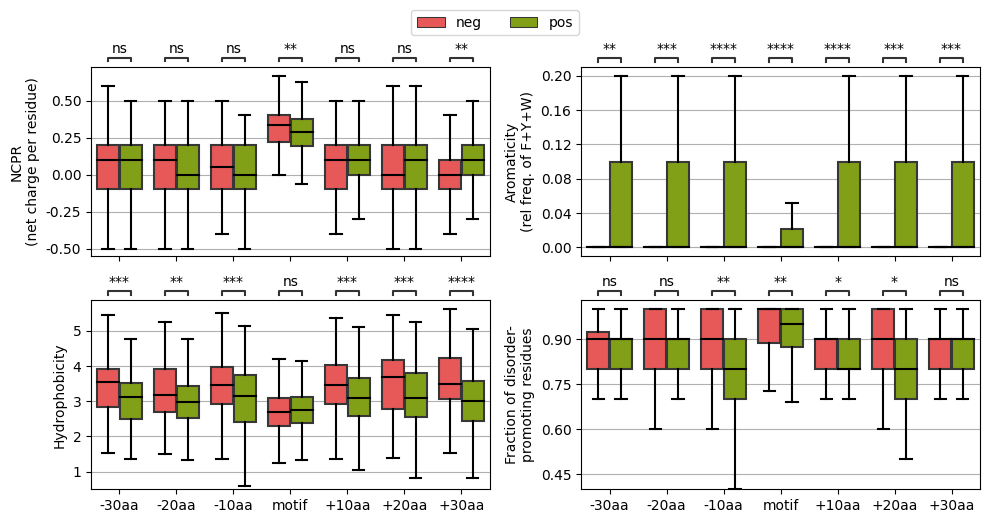

In [25]:
#### 4 figure overview

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
xticks = ["-30","-20","-10","","+10","+20","+30"] # "-40", ,"+40"
xticks_labels = [el + "aa" if el != "" else "motif" for el in xticks]


######################################

categories_ordered = ["neg", "pos"]
metric_name = "ncpr"
metrics_ordered = [metric_name + "_motif" + el for el in xticks]
# print(metrics_ordered)
# metrics_ordered = [metric_name + "_" + el for el in ["motif-40", "motif-30", "motif-20", "motif-10", "motif", "motif+10", "motif+20", "motif+30", "motif+40"]] #, "ncpr_motif-10", "ncpr_motif-5", "ncpr_motif", "ncpr_motif+5", "ncpr_motif+10", "ncpr_motif+20"
ytitle = "NCPR\n(net charge per residue)"
ylim_bottom =-0.55
decimals = 2
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[0][0],ylim_bottom, xticks_labels, decimal_places=decimals)

########################

categories_ordered =  ["neg", "pos"]
metric_name = "aroma"
metrics_ordered = [metric_name + "_motif" + el for el in xticks]
ytitle = "Aromaticity\n(rel freq. of F+Y+W)"
ylim_bottom =-0.01
decimals = 2
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[0][1], ylim_bottom, xticks_labels, decimal_places=decimals)

#########################

categories_ordered =  ["neg", "pos"]
metric_name = "hyphob"
metrics_ordered = [metric_name + "_motif" + el for el in xticks]
ytitle = "Hydrophobicity"
ylim_bottom =0.5
decimals = 0
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[1][0], ylim_bottom, xticks_labels, decimal_places=decimals)

#########################

# categories_ordered = ["neg", "pos"]
# metric_name = "kappa"
# metrics_ordered = [metric_name + "_motif" + el for el in xticks]
# ytitle = "Kappa"
# ylim_bottom =-0.1
# decimals = 1
# parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[1][0], ylim_bottom, xticks_labels, decimal_places=decimals)


#########################

categories_ordered = ["neg", "pos"]
metric_name = "disorder_promo"
metrics_ordered = [metric_name + "_motif" + el for el in xticks]
ytitle = "Fraction of disorder-\npromoting residues"
ylim_bottom =0.4
decimals = 2
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[1][1], ylim_bottom, xticks_labels, decimal_places=decimals)

#########################

# categories_ordered = ["neg", "pos"]
# metric_name = "scd"
# metrics_ordered = [metric_name + "_motif" + el for el in xticks]
# ytitle = "sequence charge\ndecoration"
# # ylim_bottom =-0.1
# decimals = 1
# parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[2][1], xticks=xticks_labels, decimal_places=decimals)

# print(fig.gca().get_legend_handles_labels())
handles, labels = [], []
for handle, label in zip(*fig.gca().get_legend_handles_labels()):
    handles.append(handle)
    labels.append(label)
# print(handles)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder +  "3_bar_properties_.svg", transparent=True)

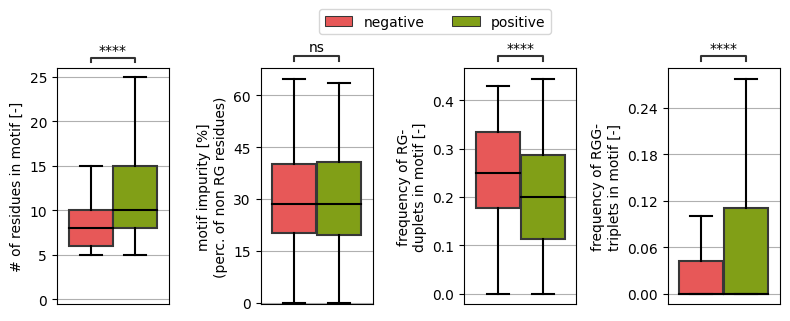

In [ ]:
#### 4 figure ion one row

fig, ax = plt.subplots(1, 4, sharex=False, figsize=(8, 3))
# xticks = ["-30aa","-20aa","-10aa","motif","+10aa","+20aa","+30aa"]
xticks = False
categories_ordered = ["neg", "pos"]
metrics_ordered = ["len_motif"]
ytitle = "# of residues in motif [-]"
ylim_bottom =-0.55
decimals = 0
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[0], ylim_bottom,  xticks, decimal_places=decimals)

########################

categories_ordered = ["neg", "pos"]
metrics_ordered = ["perc_impure"]
ytitle = "motif impurity [%]\n(perc. of non RG residues)"
ylim_bottom =-0.55
decimals = 0
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[1], ylim_bottom, decimal_places=decimals)
plt.tight_layout()


#########################

# xticks = ["RG_count"] #, "RGG_count"]
categories_ordered = ["neg", "pos"]
metrics_ordered = ["RG_count_rel"]
ytitle = "frequency of RG-\nduplets in motif [-]"
# ylim_bottom =-0
decimals = 1
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[2], xticks, style='b', decimal_places=decimals, scatter=False)
#########################

# xticks = ["RG_count"] #, "RGG_count"]
categories_ordered = ["neg", "pos"]
metrics_ordered = ["RGG_count_rel"]
ytitle = "frequency of RGG-\ntriplets in motif [-]"
# ylim_bottom =-0.25
decimals = 2
parent_create_boxplot_with_dots(categories_ordered, metrics_ordered, ytitle, ax[3], xticks, style='b', decimal_places=decimals, scatter=False)

handles, labels = [], []
for handle, label in zip(*fig.gca().get_legend_handles_labels()):
    handles.append(handle)
    labels.append(label)

fig.legend(handles, ["negative", "positive"], loc='upper center', bbox_to_anchor=(0.55, 1.08), ncol=2)
plt.tight_layout()

subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder + "1_general.svg", transparent=True)

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare amino acid groupings
amino_acid_groupings = [
    ["F", "Y", "W"], 
    ["E", "D", "N", "Q"], 
    ["L", "V", "I", "M", "C"], 
    ["K", "H"], 
    ["A", "S", "T", "P"]
]
amino_acids_high_values = ["R", "G"]

# Define bar width and color mapping
bar_width = 0.30

# Create the main figure with an additional subplot for R and G
fig, ax = plt.subplots(2, 6, sharey='row', figsize=(11, 3),
                       gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [len(el) for el in amino_acid_groupings] + [2]})

# Function to plot the barplots for grouped amino acids
def plot_group(ax, group_proportions, avg_proportions, group, els, bar_width, row, col):
    # Extract and sort proportions
    curr_group_proportions_neg = group_proportions.loc["neg", els]
    curr_group_proportions_pos = group_proportions.loc["pos", els]
    difference = curr_group_proportions_pos - curr_group_proportions_neg
    difference_sorted = difference.sort_values(ascending=False)
    keys_sorted = difference_sorted.index

    # Sort proportions by the sorted order
    curr_group_proportions_neg = curr_group_proportions_neg.loc[keys_sorted]
    curr_group_proportions_pos = curr_group_proportions_pos.loc[keys_sorted]
    indices = np.arange(len(els))

    # Top row: Stacked bar plot for proportions
    ax[0, col].bar(indices - bar_width / 2, curr_group_proportions_neg, bar_width, 
                   label="neg", color="#FF4040", edgecolor="black")
    ax[0, col].bar(indices + bar_width / 2, curr_group_proportions_pos, bar_width, 
                   label="pos", color="#8DB600", edgecolor="black")
    ax[0, col].bar(indices, [avg_proportions[aa] for aa in keys_sorted], bar_width * 0.8, 
                   fill=False, edgecolor="black", linestyle="dotted")
    ax[0, col].set_xticks([])
    ax[0, col].grid(axis="y", zorder=0)
    ax[0, 0].set_ylabel("Proportion of amino acid\nin motif [%]")
    ax[0, col].set_axisbelow(True)
    ax[0, col].tick_params(axis='y', length=0)
    ax[0, col].tick_params(axis='x', length=0)
    ax[0, 0].tick_params(axis='y', length=3)

    # Bottom row: Bar plot for differences
    ax[1, col].bar(indices, difference_sorted, color="#A9A9A9", edgecolor="black")
    ax[1, col].set_xticks(indices)
    ax[1, col].set_xticklabels(keys_sorted)
    ax[1, col].grid(axis="y", zorder=0)
    ax[1, col].set_axisbelow(True)
    ax[1, col].tick_params(axis='y', length=0)
    ax[1, col].tick_params(axis='x', length=0)
    ax[1, 0].tick_params(axis='y', length=3)
    ax[1, col].set_ylim(-3,3)

# Function to plot the separate R and G subplot
def plot_high_values(ax, group_proportions, avg_proportions, amino_acids, col):
    # Extract data for R and G
    curr_group_proportions_neg = group_proportions.loc["neg", amino_acids]
    curr_group_proportions_pos = group_proportions.loc["pos", amino_acids]
    indices = np.arange(len(amino_acids))
    
    # Create twin axis for the larger scale
    twin_ax = ax[0, col].twinx()
    
    # Bar plots for R and G
    twin_ax.bar(indices - bar_width / 2, curr_group_proportions_neg, bar_width, 
                label="neg", color="#FF4040", edgecolor="black")
    twin_ax.bar(indices + bar_width / 2, curr_group_proportions_pos, bar_width, 
                label="pos", color="#8DB600", edgecolor="black")
    twin_ax.bar(indices, [avg_proportions[aa] for aa in amino_acids], bar_width * 0.8, 
                fill=False, edgecolor="black", linestyle="dotted")
    twin_ax.set_ylabel("Proportion of R & G in motif [%] ")
    twin_ax.grid(axis="y", zorder=0)
    twin_ax.set_axisbelow(True)

    # Difference plot
    twin_ax_1 = ax[1, col].twinx()
    difference = curr_group_proportions_pos - curr_group_proportions_neg
    twin_ax_1.bar(indices, difference, color="#A9A9A9", edgecolor="black")
    twin_ax_1.set_xticks(indices)
    twin_ax_1.set_xticklabels(amino_acids)
    twin_ax_1.grid(axis="y", zorder=0)
    twin_ax_1.set_axisbelow(True)
    twin_ax_1.set_ylim(-6,6)

# Plot the grouped amino acids
for i, group in enumerate(amino_acid_groupings):
    plot_group(ax, group_proportions, avg_proportions, group, group, bar_width, row=0, col=i)

# Plot the separate R and G subplot
plot_high_values(ax, group_proportions, avg_proportions, amino_acids_high_values, col=5)

# Adjust layout and add legend
fig.tight_layout()
plt.subplots_adjust(hspace=0.09, wspace=0)
curr_pos_0 = ax[0,5].get_position()
ax[0, 5].set_position([curr_pos_0.x0 + 0.01, curr_pos_0.y0, curr_pos_0.width, curr_pos_0.height])
ax[0, 5].tick_params(axis='y', left=False)
curr_pos_1 = ax[1,5].get_position()
ax[1, 5].set_position([curr_pos_1.x0 + 0.01, curr_pos_1.y0, curr_pos_1.width, curr_pos_1.height])
ax[1, 5].tick_params(axis='y', left=False)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, ["negative", "positive"], loc="upper center", bbox_to_anchor=(0.5, 1.07), ncol=2)
subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder +  "3_bar_AA_.svg", transparent=True)
plt.show()


         A   C    D   E   F     G   H   I   K   L   M   N    P   Q     R    S  \
Group                                                                           
neg    105  19   24  53   7   809  12  11  33  56   3   7  144  32   713  113   
pos     96   9  113  67  82  1657  33  21  49  60  40  52  181  34  1099  186   

        T   V   W   Y  
Group                  
neg    37  18  12   3  
pos    44  29   5  44  


/tmp/ipykernel_21831/1730137192.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_sums = df_expanded.groupby('Group').sum()
